In [16]:
# import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pickle

# import calculation libraries
from scipy.integrate import odeint
from scipy import integrate, optimize

# time libraries
import datetime
from datetime import datetime

def SEIR(y, t, beta, gamma1, gamma2, alpha, d1, r):
    #unpackage paraments
    S, E, I, R, total_death= y
    #S, E, I, R = y

    # calculte curve
    dS_dt = -beta*S*I*r/N
    dE_dt = beta*S*I*r/N - gamma1*E - alpha*E
    dI_dt = alpha*E - gamma2*I - d1*I
    dR_dt = gamma1*E + gamma2*I

    # the data we want to find
    # total_death = d1*I
    total_confirmed = alpha*E

    # return result
    return([dS_dt, dE_dt, dI_dt, dR_dt, total_confirmed])
    
def fit_odeint(t,beta,gamma1,gamma2,alpha,d1,r):
    re = integrate.odeint(SEIR,[S0,E0,I0,R0,total_confirmed],t,args=(beta,gamma1,gamma2,alpha,d1,r))
    return re[:,-1]

countries = ['Italy','Japan','China','United Kingdom','Spain','Iran','France','Germany']
add_dates = ['4/15/20','4/16/20','4/17/20','4/18/20','4/19/20','4/20/20','4/21/20','4/22/20','4/23/20','4/24/20','4/25/20','4/26/20','4/27/20','4/28/20','4/29/20','4/30/20','5/1/20']

re = {}

In [7]:
with open('../data/Confirmed_prediction','rb') as f:
    result_data = pickle.load(f)
    actual_curve = result_data['actual_curve']
    fitted_curve = result_data['fitted_curve']
    prediction_curve = result_data['prediction_curve']

In [8]:
# load data
confirmed_data = pd.read_csv('../input/novel-corona-virus-2019-dataset/time_series_covid_19_confirmed.csv')
deaths_data = pd.read_csv('../input/novel-corona-virus-2019-dataset/time_series_covid_19_deaths.csv')
country_pop = pd.read_csv('../input/population-by-country-2020/population_by_country_2020.csv')

country_pop = country_pop.rename(columns={'Country (or dependency)':'Country','Population (2020)':'Population'})
deaths_data = deaths_data.rename(columns={'Province/State':'State','Country/Region':'Country'})
confirmed_data = confirmed_data.rename(columns={'Province/State':'State','Country/Region':'Country'})

In [38]:
dates = deaths_data.loc[:,'1/22/20':]
dates = list(dates.columns.values)

In [28]:
with open('../data/Confirmed_prediction','rb') as f:
    result_data = pickle.load(f)
result_data['prediction_curve'].keys()

dict_keys(['France', 'Spain', 'UK', 'Germany', 'Italy', 'Iran'])

In [33]:
actual_curve = {}
fitted_curve = {}
prediction_curve = {}

In [209]:
country = 'Iran'
confirmed_data_copy = confirmed_data.loc[confirmed_data['Country']==country]
confirmed = confirmed_data_copy.iloc[:,4:].sum(axis = 0)
confirmed

1/22/20        0
1/23/20        0
1/24/20        0
1/25/20        0
1/26/20        0
           ...  
4/10/20    68192
4/11/20    70029
4/12/20    71686
4/13/20    73303
4/14/20    74877
Length: 84, dtype: int64

In [316]:
# get N
country = 'Japan'
population = country_pop.loc[country_pop['Country']==country,'Population']
N = population.iloc[0]

# confirmed data
confirmed_data_copy = confirmed_data.loc[confirmed_data['Country']==country]
confirmed = confirmed_data_copy.iloc[:,4:].sum(axis = 0)
I0 = confirmed[0]

# y_data = [0 for i in range(7)]
# for value in confirmed.values:
#     y_data.append(value)
y_data = confirmed.values
x_data = [i+1 for i in range(len(y_data))]
y_data = np.array(y_data)
x_data = np.array(x_data)

min_diff = 9999999
for E0 in range(confirmed[0],2001,40):

    I0 = confirmed[0] # inital Exposed          
    S0 = N - I0 - E0 # inital Susceptible

    # other parameters
    R0 = 0 # inital recovered
    total_death = 0
    total_confirmed = x_data[0]

    y = S0,E0,I0,R0,total_confirmed

    # fitting
    popt, _ = optimize.curve_fit(fit_odeint,x_data,y_data,maxfev=5000)
    fitted = fit_odeint(x_data, *popt)

    # calculte diff
    diff = 0
    for i in range(1,3):
        #diff += abs(fitted[-i]-y_data[-i])
        diff += abs(fitted[-i]-fitted[-i-1]-y_data[-i]+y_data[-i-1])
        #diff += abs(fitted[-i-1]-y_data[-i-1])
    if diff < min_diff:
        min_diff = diff
        re[country] = [popt] + [E0] + [I0]

print(country+' is Complete!')

t = [i+1 for i in range(len(x_data)+17)]
t = np.array(t)

    #predict
popt = re[country][0]
E0 = re[country][1]
I0 = re[country][2]

fitted2 = fit_odeint(t, *popt)
fitted1 = fit_odeint(x_data, *popt)

Japan is Complete!


In [317]:
print(y_data[-1],fitted1[-1],fitted2[-1])
print(popt,E0,I0)

7645 5861.73369216039 13487.423805824377
[ 1.28344636  2.13003455  0.10970008  0.13222848 -0.06285662  1.30258909] 922 2


In [318]:
print(len(fitted1))

84


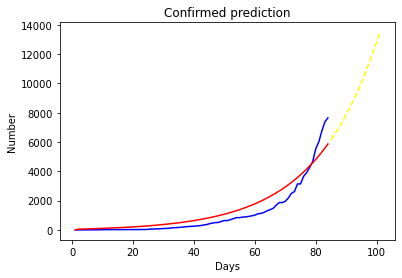

In [319]:
plt.plot(x_data, y_data, color = 'b')
plt.plot(x_data, fitted1, color = 'r')
plt.plot(t[-17:], fitted2[-17:], color = 'yellow',ls='--')

plt.title("Confirmed prediction")
plt.ylabel("Number")
plt.xlabel("Days")
plt.show()

In [305]:
print(y_data[-1])
print(fitted1[-1])
print(fitted2[-1])

172541
208579.45013001867
664584.699217738


In [281]:
print(len(y_data),len(fitted1),len(fitted2))

84 84 101


In [282]:
actual_curve[country] = {}
fitted_curve[country] = {}
prediction_curve[country] = {}

actual_curve = pd.Series(y_data, dates)
fitted_curve = pd.Series(fitted1, dates)
prediction_curve = pd.Series(fitted2, dates+add_dates)

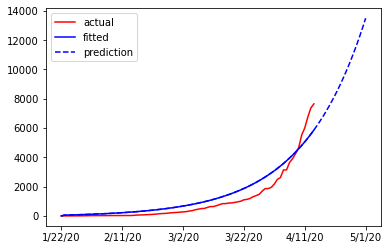

In [283]:
fig,(ax1) = plt.subplots(1, 1)

actual_curve.plot(ax=ax1,label = 'actual',color = 'r')
fitted_curve.plot(ax=ax1,label = 'fitted',color = 'b')
prediction_curve.plot(ax=ax1,label = 'prediction',color = 'b',ls='--')

plt.legend()
plt.show()

In [284]:
prediction_curve.keys()

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       ...
       '4/22/20', '4/23/20', '4/24/20', '4/25/20', '4/26/20', '4/27/20',
       '4/28/20', '4/29/20', '4/30/20', '5/1/20'],
      dtype='object', length=101)

In [285]:
result_data['prediction_curve'][country] = prediction_curve
result_data['fitted_curve'][country] = fitted_curve
result_data['actual_curve'][country] = actual_curve


In [286]:
result_data['prediction_curve'].keys()

dict_keys(['France', 'Spain', 'UK', 'Germany', 'Italy', 'Iran', 'China', 'US', 'Japan'])

In [287]:
import pickle
with open('../data/Confirmed_prediction','wb') as f:
    pickle.dump(result_data,f)

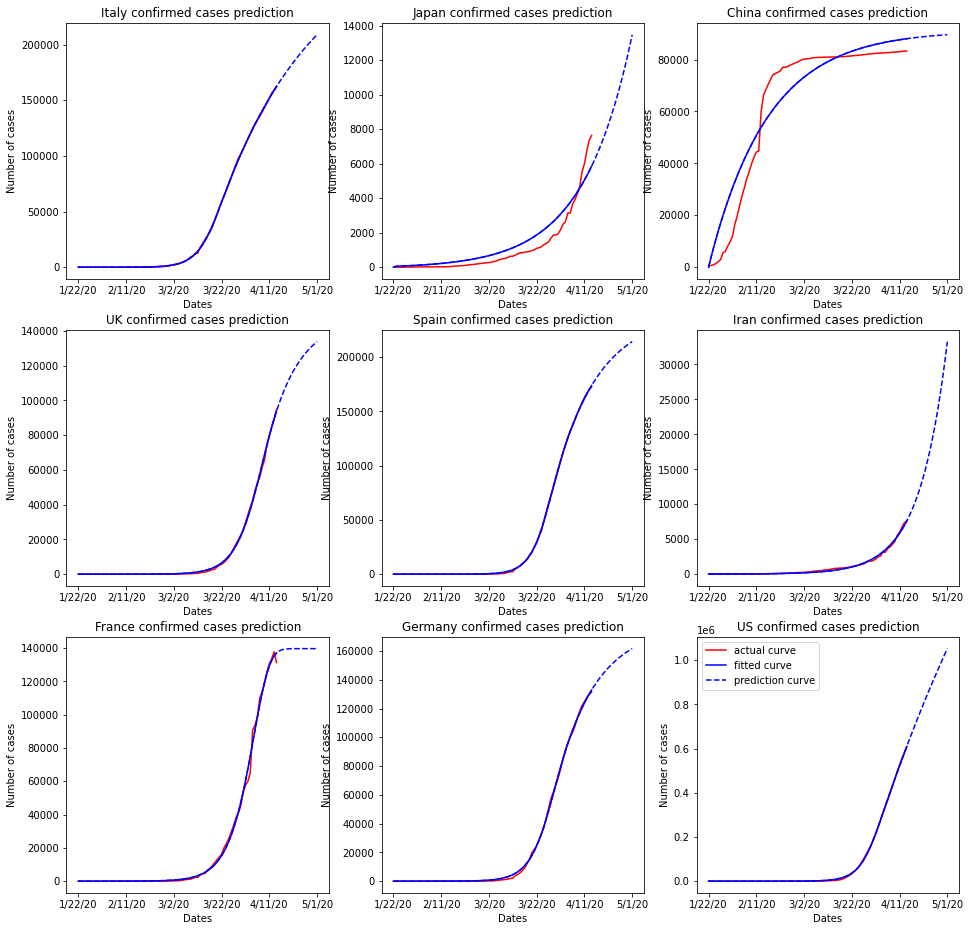

In [288]:
countries = ['Italy','Japan','China','UK','Spain','Iran','France','Germany','US']
fig,axs = plt.subplots(3, 3,figsize = (16,16))
for index,country in enumerate(countries):
    # get loc
    i = int(index / 3)
    j = int(index % 3)
    ax = axs[i][j]

    # load curve
    actual_curve = pd.Series(result_data['actual_curve'][country])   
    fitted_curve = pd.Series(result_data['fitted_curve'][country])
    prediction_curve = pd.Series(result_data['prediction_curve'][country])

    # plot
    actual_curve.plot(ax=ax,label ='actual curve',color = 'r')
    fitted_curve.plot(ax=ax,label ='fitted curve',color = 'b')
    prediction_curve.plot(ax=ax,label ='prediction curve',color = 'b',ls='--')
    ax.set_title(country+' confirmed cases prediction')
    ax.set_ylabel("Number of cases")
    ax.set_xlabel("Dates")

#fig.suptitle('Confirmed cases prediction')
plt.legend()
plt.savefig("../graphs/Confirmed cases prediction")
plt.show()